In [8]:
#Miscellaneous
import os
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

#For data manipulation
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image, ImageEnhance

#For neural network
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

In [9]:
#Load Training Data
train_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

#Concatenate data paths
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')

train_df = pd.concat([Fseries, Lseries], axis = 1)

In [10]:
#Load Testing Data
train_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

#Concatenate data paths
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name ='labels')

ts_df = pd.concat([Fseries, Lseries], axis = 1)

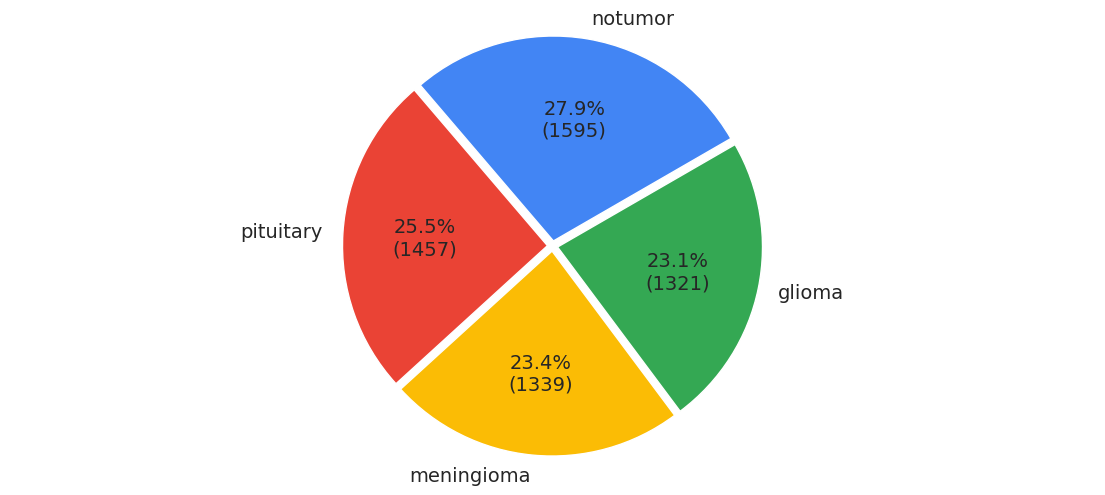

In [11]:
#Graph Dataset Split
plt.figure(figsize = (14, 6))
plt.rcParams.update({'font.size': 14})
data_balance = train_df.labels.value_counts()

def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct * total / 100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

plt.pie(data_balance,
        labels = data_balance.index,
        autopct = custom_autopct,
        colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853'],
        explode = (0.025, 0.025, 0.025, 0.025),
        startangle = 30);
plt.axis('equal')
plt.show()


In [12]:
#Split dataset
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [13]:
#Augment and Preprocess Scans
batch_size = 32
img_size = (240, 240)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = True, batch_size = batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


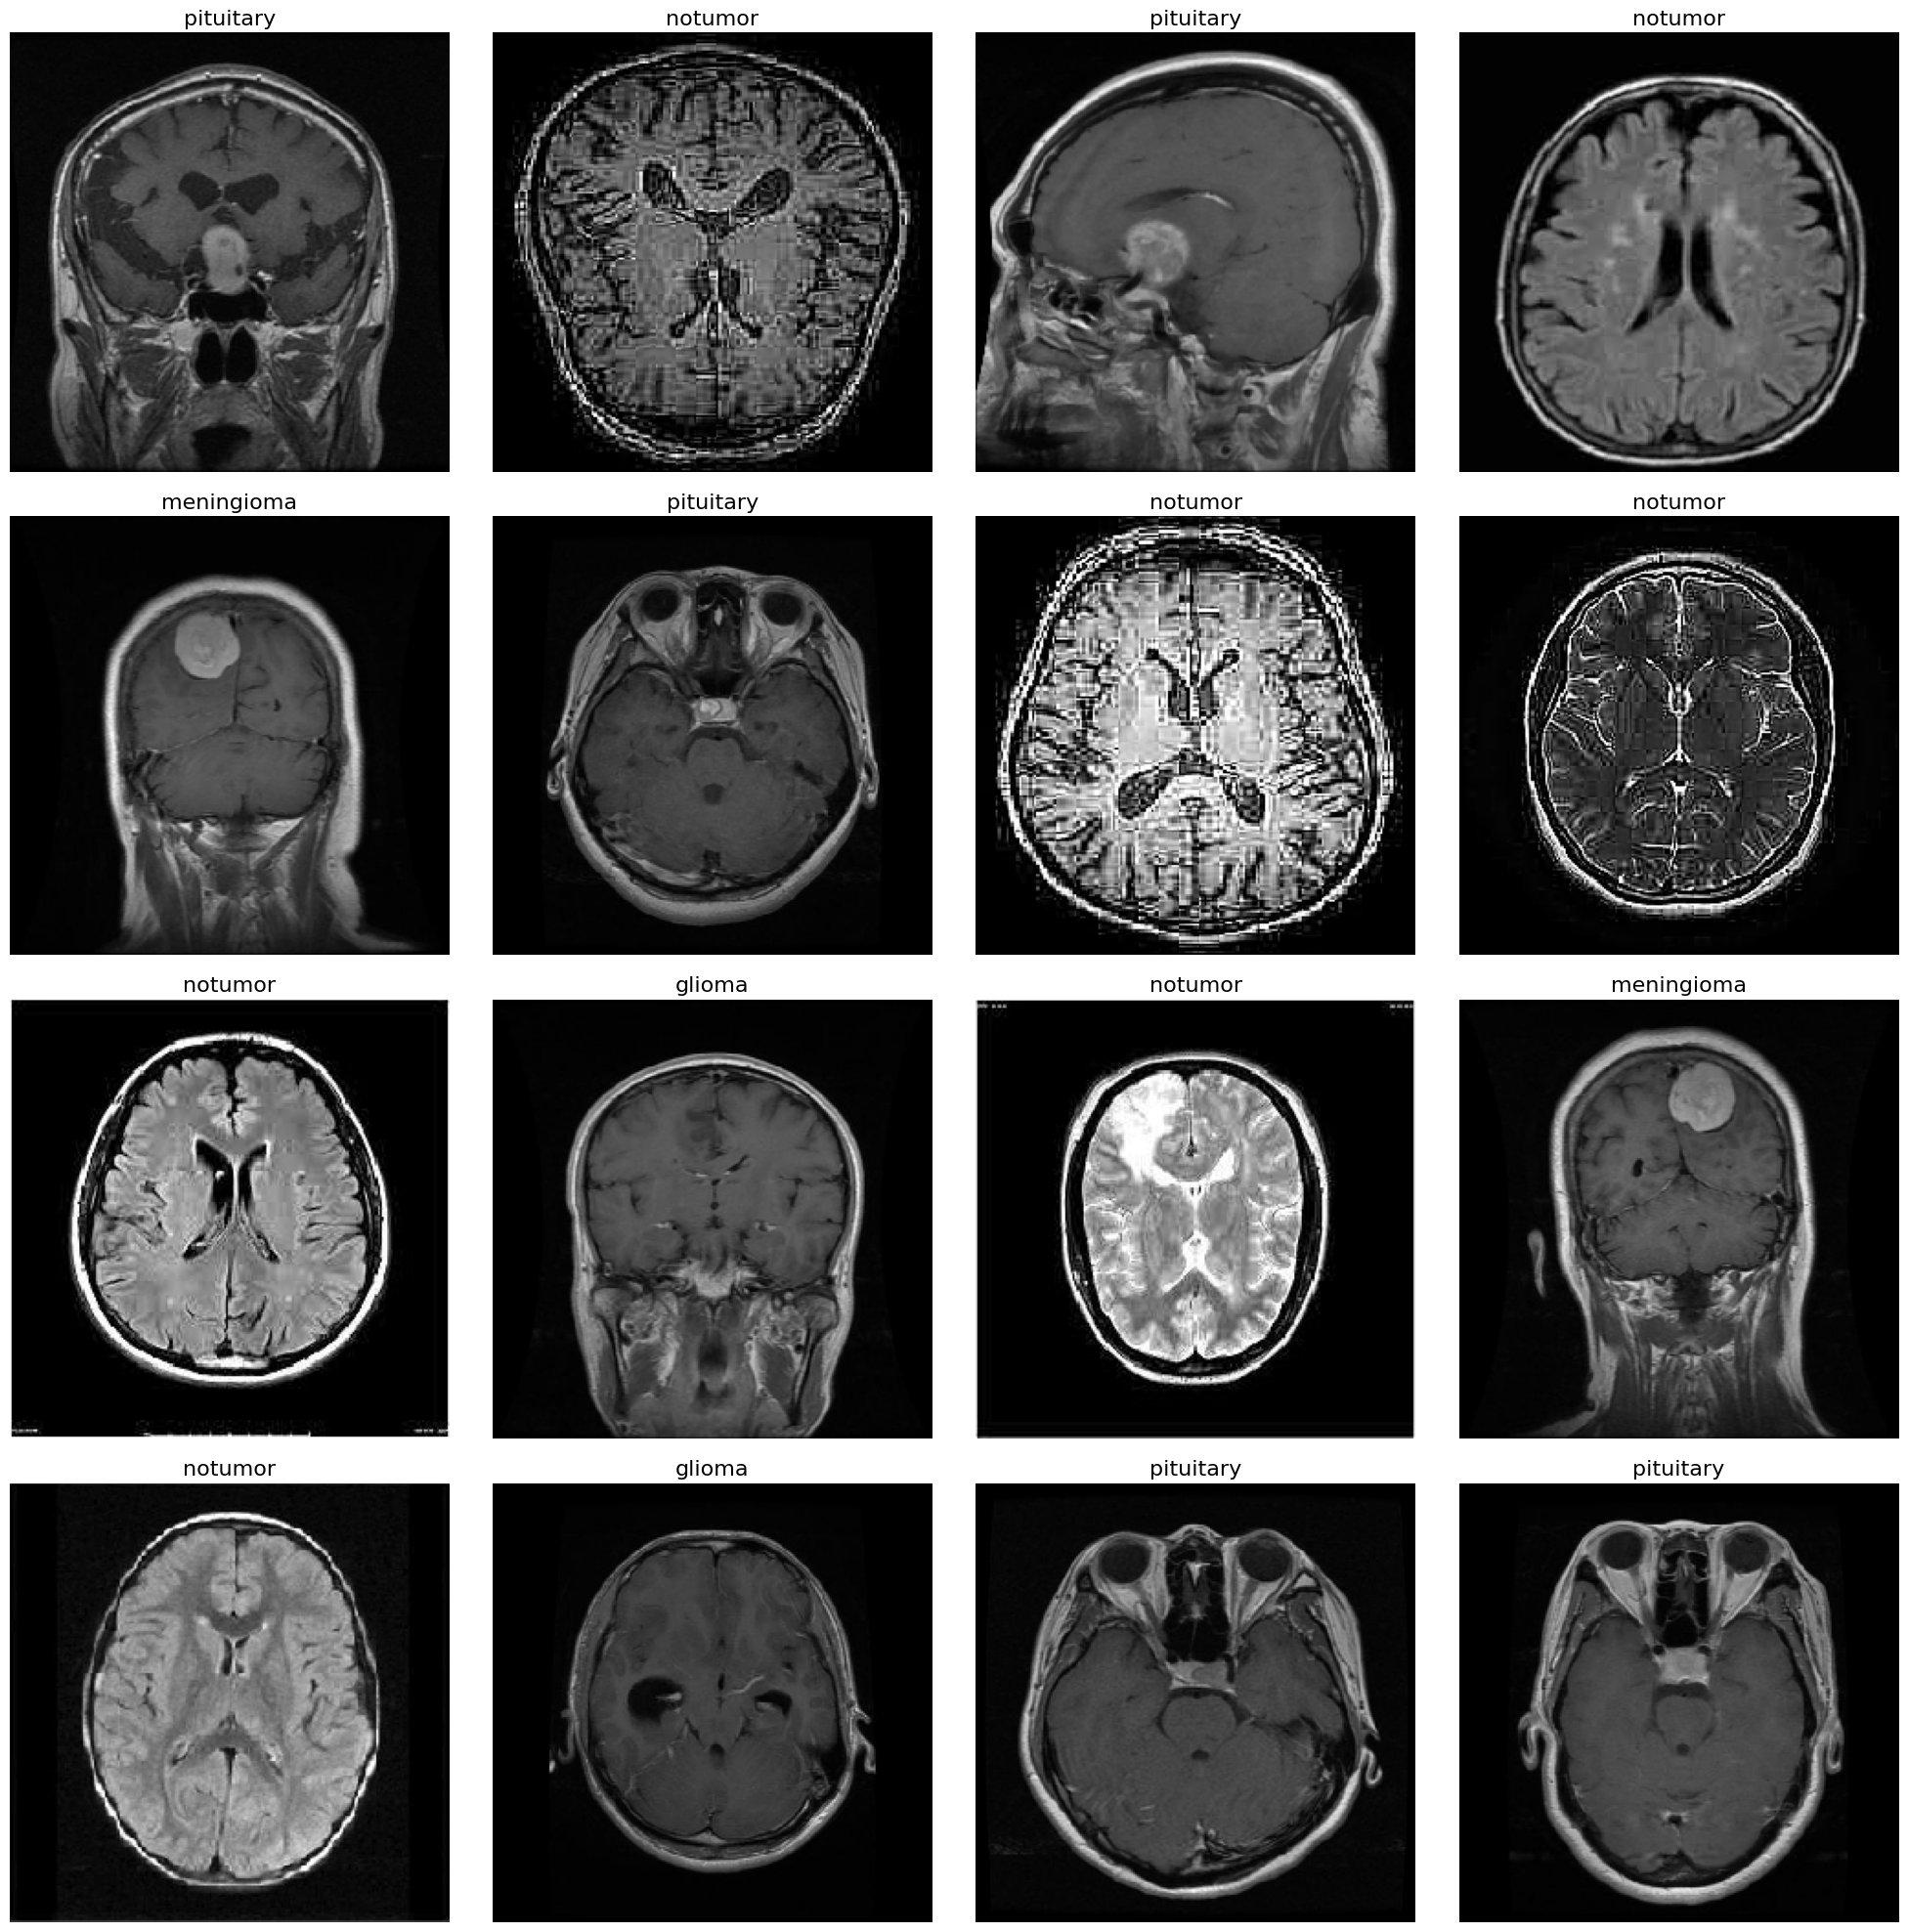

In [14]:
#Plot Processed Scans
g_dict = train_gen.class_indices     
classes = list(g_dict.keys())       
images, labels = next(train_gen)     

plt.figure(figsize = (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255     
    plt.imshow(image)
    index = np.argmax(labels[i]) 
    class_name = classes[index]  
    plt.title(class_name, color = 'black', fontsize = 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

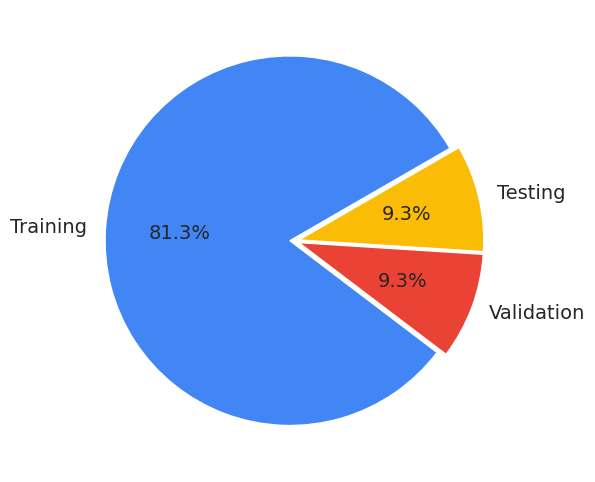

In [15]:
#Graph Dataset Directories
plt.figure(figsize = (14, 6))
plt.rcParams.update({'font.size': 14})

plt.pie([len(train_df), len(valid_df), len(test_df)],
        labels = ['Training','Validation', 'Testing'],
        colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853'], 
        autopct = '%.1f%%', 
        explode = (0.025, 0.025, 0.025),
        startangle = 30);


In [16]:
#Create model architecture
img_size = 240
class_count = len(list(train_gen.class_indices.keys()))

base_model = VGG19(input_shape = (img_size, img_size, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()

model.add(Input(shape = (img_size, img_size, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(class_count, activation = 'softmax'))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,236,292 (88.64 MB)

 Trainable params: 10,291,332 (39.26 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

In [18]:
#LETS GO! NO ERRORS! Time to compile
model.compile(optimizer = Adam(learning_rate = 0.0001),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

batch_size = 32
epochs = 20
history = model.fit(train_gen, 
                    epochs = epochs, 
                    verbose = 1, 
                    validation_data = valid_gen, 
                    shuffle = False)

Epoch 1/20


I0000 00:00:1733605978.892184     132 service.cc:145] XLA service 0x7e3518001ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733605978.892268     132 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/179 ━━━━━━━━━━━━━━━━━━━━ 44:35 15s/step - accuracy: 0.4062 - loss: 17.9863

I0000 00:00:1733605991.943218     132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 66s 285ms/step - accuracy: 0.6726 - loss: 1.9104 - val_accuracy: 0.8947 - val_loss: 0.2892
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.8840 - loss: 0.3184 - val_accuracy: 0.9191 - val_loss: 0.2121
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.9330 - loss: 0.1944 - val_accuracy: 0.9511 - val_loss: 0.1188
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.9469 - loss: 0.1488 - val_accuracy: 0.9634 - val_loss: 0.0945
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.9680 - loss: 0.0903 - val_accuracy: 0.9679 - val_loss: 0.0969
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.9777 - loss: 0.0604 - val_accuracy: 0.9679 - val_loss: 0.1093
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.9783 - loss: 0.0672 - val_accuracy: 0.9756 - val_loss: 0.0723
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.9828 - loss: 0.0518 - val

In [20]:
from sklearn.metrics import classification_report

# Assuming you have test data loaded in test_gen and a trained model named 'model'
# Predict the classes for the test set
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_gen.classes

# Get class labels
class_labels = list(test_gen.class_indices.keys())

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step
              precision    recall  f1-score   support

      glioma       0.96      1.00      0.98       149
  meningioma       0.99      0.95      0.97       148
     notumor       1.00      1.00      1.00       208
   pituitary       0.99      0.99      0.99       151

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



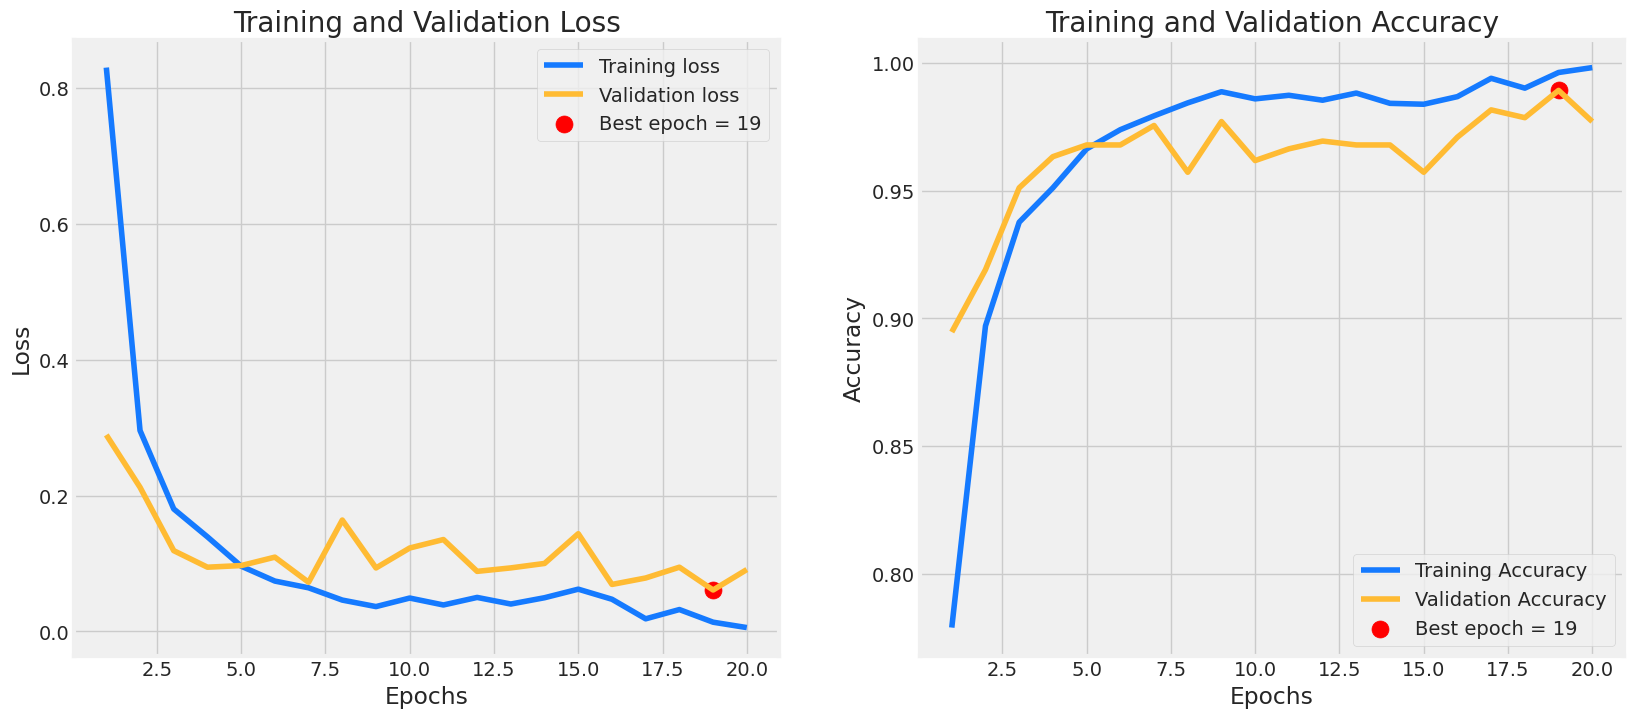

In [19]:
#Graph results
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

plt.figure(figsize = (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color = '#157AFF', label = 'Training loss')
plt.plot(Epochs, val_loss, color = '#FFBB33', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s = 150, color = 'red', label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color = '#157AFF', label = 'Training Accuracy')
plt.plot(Epochs, val_acc, color = '#FFBB33', label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s = 150, color = 'red', label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [21]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Assuming you have test data loaded in test_gen and a trained model named 'model'
# Predict the classes for the test set
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_gen.classes

# Get class labels
class_labels = list(test_gen.class_indices.keys())

# Generate classification report as a dictionary
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

# Calculate overall weighted precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the final precision, recall, and F1-score
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
Precision: 0.9836
Recall: 0.9832
F1 Score: 0.9832
